[CausalInference package tutorial](http://www.degeneratestate.org/posts/2018/Mar/24/causal-inference-with-python-part-1-potential-outcomes/)

In [1]:
from __future__ import division

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_column', 200)

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline

In [2]:
gdf = gpd.read_file("clean_data/master.shp")

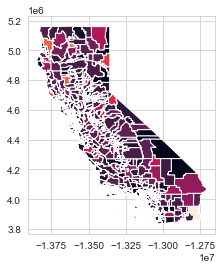

In [16]:
gdf.plot('SuspPct')

In [3]:
df = pd.DataFrame(gdf)

In [4]:
df['concentrat'] = df['concentrat'].replace('-', np.nan) 

In [5]:
df.columns = df.columns.str.replace(' ', '_')

In [6]:
df["concentrat"].fillna("0", inplace = True) 

In [7]:
df["concentrat"].fillna("0", inplace = True)
# filling nan values with 0

def treatment(df): # create treatment function
    if df['concentrat'] == '0':
        return '0'
    else:
        return '1'

df['treatment'] = df.apply(treatment, axis=1)
# execute function to create treatment dummy variable

df.treatment = df.treatment.astype(int)
# change to int, diff_means function wont work otherwise

In [8]:
def diff_means(df, y='m_curr_ALL'): # enter dataframe, then variable
    
    control = df[df.treatment == 0] # defining control group
    treat = df[df.treatment == 1] # defining treatment group
    ncontrol = control.shape[0]
    ntreat = treat.shape[0]
    
    delta = treat[y].mean() - control[y].mean()   # difference between means
    delta_err = 1.96 * np.sqrt(                  # standard error = square root(variance(Y1) / N(Y1) + variance(Y0) / N(Y0))
        treat[y].var() / ntreat + 
        control[y].var() / ncontrol)

    degfree = 2 * (ntreat+ncontrol) - 2
    p = 1 - stats.t.cdf(delta,df=degfree)
    
    return {"estimated_effect": delta, "standard_error": delta_err, "p_value":p}

In [9]:
diff_means(df, 'm_prio_ALL')
# p_value calculator seems stuck on '1'

{'estimated_effect': -57.61190900319156,
 'standard_error': 4.462574778908788,
 'p_value': 1.0}

Chi2 statistical test

In [10]:
contingency_table = (
    df['m_curr_ALL'],
    df['treatment'])
_, p, _, _ = chi2_contingency(contingency_table, lambda_="log-likelihood")

# p-value
p
# how else to get p?

NameError: name 'chi2_contingency' is not defined

## moving on

In [ ]:
df.plot.scatter(x='total_gran', y='m_curr_ALL', c='treatment', cmap='rainbow', colorbar=True)

In [ ]:
df

In [ ]:
from causalinference import CausalModel
# CausalModel params:
# y = outcomes
# d = treatment
# X = covariates

[causalinference api](https://causalinferenceinpython.org/causalinference.html#module-causalinference.causal)

In [ ]:
cm = CausalModel(
    Y=df.m_curr_ALL.values,
    D=df.treatment.values,
    X=df.e_curr_ALL.values)

cm.est_via_ols(adj=0)

print(cm.estimates)

# problem because data not linear enough?

In [ ]:
cm = CausalModel(
    Y=df.m_curr_ALL.values, 
    D=df.treatment.values, 
    X=df.e_curr_ALL.values)

cm.est_via_matching()

print(cm.estimates)

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
results = smf.ols(formula='m_curr_ALL ~ treatment', data=df,).fit()
print(results.summary())